In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os,gc,re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import time
plt.style.use('seaborn-whitegrid')
import warnings
warnings.simplefilter("ignore")
colors = [x['color'] for x in plt.rcParams['axes.prop_cycle']]


from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/iee-fraud detection')

In [ ]:
!nvidia-smi

Sat Apr  3 10:43:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
df_train = pd.read_csv('data/train_combined.csv')
df_test = pd.read_csv('data/test_combined.csv')

In [ ]:
# column details
cat_cols = (['ProductCD'] + 
            ['card%d' % i for i in range(1, 7)] + 
            ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            ['M%d' % i for i in range(1, 10)] + 
            ['DeviceType', 'DeviceInfo'] +
            ['id_%d' % i for i in range(12, 39)])


type_map = {c: str for c in cat_cols}
df_train[cat_cols] = df_train[cat_cols].astype(type_map, copy=False)
df_test[cat_cols] = df_test[cat_cols].astype(type_map, copy=False)

######################################################################################

id_cols = ['TransactionID', 'TransactionDT']
target = 'isFraud'

numeric_cols =  [
    'TransactionAmt', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 
    'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 
    'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 
    'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 
    'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 
    'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 
    'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 
    'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 
    'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 
    'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 
    'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 
    'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 
    'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 
    'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 
    'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 
    'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 
    'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 
    'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 
    'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 
    'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 
    'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 
    'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 
    'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 
    'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 
    'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
    'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 
    'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 
    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 
    'V337', 'V338', 'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 
    'id_09', 'id_10', 'id_11'
]

v_cols_included = ['V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 
 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 
 'V62', 'V65', 'V67', 'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89', 'V91', 'V96', 
 'V98', 'V99', 'V104', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121', 'V123', 'V124', 'V127', 
 'V129', 'V130', 'V136', 'V138', 'V139', 'V142', 'V147', 'V156', 'V162', 'V165', 'V160', 'V166', 'V178',
 'V176', 'V173', 'V182', 'V187', 'V203', 'V205', 'V207', 'V215', 'V169', 'V171', 'V175', 'V180', 'V185', 
 'V188', 'V198', 'V210', 'V209', 'V218', 'V223', 'V224', 'V226', 'V228', 'V229', 'V235', 'V240', 'V258', 
 'V257', 'V253', 'V252', 'V260', 'V261', 'V264', 'V266', 'V267', 'V274', 'V277', 'V220', 'V221', 'V234', 
 'V238', 'V250', 'V271', 'V294', 'V284', 'V285', 'V286', 'V291',
 'V297', 'V303', 'V305', 'V307', 'V309', 'V310', 'V320', 'V281', 'V283', 'V289', 'V296', 'V301', 'V314', 'V332', 'V325', 'V335', 'V338']



In [ ]:
# droping v cols 
drop_cols = [col for col in df_train.columns if col[0] == 'V' and col not in v_cols_included]

print(f'dropping {len(drop_cols)} columns')
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

dropping 211 columns


In [ ]:
## Train and test split¶
y_train = df_train['isFraud']
X_train = df_train.drop(columns=['isFraud'])
X_test = df_test.copy()

print(X_train.shape)
print(X_test.shape)
gc.collect()

(590540, 222)
(506691, 222)


103

In [ ]:
# Label encoding all cat features
for col in X_train.columns:
    if col in cat_cols:
        # label encode all cat columns
        dff = pd.concat([X_train[col],X_test[col]])
        dff,_ = pd.factorize(dff,sort=True)
        if dff.max()>32000: 
            print(col,'needs int32 datatype')
            
        X_train[col] = dff[:len(X_train)].astype('int16')
        X_test[col] = dff[len(X_train):].astype('int16')

In [ ]:
# normalize d cols
norm_cols =  [15, 4, 2, 11, 10]
for i in range(1,16):
  if i in norm_cols:
      X_train['D'+str(i)+'n'] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
      X_test['D'+str(i)+'n'] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60)

# hour column

X_train['hour'] = (X_train['TransactionDT']//(60*60))%24
X_test['hour'] = (X_test['TransactionDT']//(60*60))%24


### encoding feats

In [ ]:
# frequency encode columns
def frequency_encode(df1, df2, cols):
    """
    it combines train and test dataframes and then encodes
    """
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(f"'{nm}'",", ",end=" ")

def label_encode(df_train,df_test,col):
    """
    label encode a particular column
    Also memory usage is reduced
    """
    
    dff = pd.concat([df_train[col],df_test[col]])
    # sort = True just make sure that the values are sorted before label encoding
    # ['b', 'b', 'a', 'c'] will be [1,1,0,2] with sort and without sort it will be [0,0,1,2]
    dff,_ = pd.factorize(dff,sort=True)
    if dff.max() > 32000:
        df_train[col] = dff[0:len(df_train)].astype('int32')
        df_test[col] = dff[len(df_train):].astype('int32')
    else:
        df_train[col] = dff[0:len(df_train)].astype('int16')
        df_test[col] = dff[len(df_train):].astype('int16')
    del dff,_
    gc.collect()

def combine_cols(col1,col2,df_train,df_test):
    name = col1 + '_' + col2
    df_train[name] = df_train[col1].astype(str)+'_'+df_train[col2].astype(str)
    df_test[name] = df_test[col1].astype(str)+'_'+df_test[col2].astype(str)
    label_encode(df_train,df_test,name)
    print(f"'{name}'",", ",end=" ")



## FFS

In [ ]:
frequency_encode(X_train,X_test,['addr1','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain'])

# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
combine_cols('card1','addr1',X_train,X_test)
combine_cols('card2','addr1',X_train,X_test)
combine_cols('card3','addr1',X_train,X_test)
combine_cols('card4','addr1',X_train,X_test)
combine_cols('card5','addr1',X_train,X_test)
combine_cols('card6','addr1',X_train,X_test)

combine_cols('card1_addr1','P_emaildomain',X_train,X_test)
combine_cols('card2_addr1','P_emaildomain',X_train,X_test)
combine_cols('card3_addr1','P_emaildomain',X_train,X_test)
combine_cols('card4_addr1','P_emaildomain',X_train,X_test)
combine_cols('card5_addr1','P_emaildomain',X_train,X_test)
combine_cols('card6_addr1','P_emaildomain',X_train,X_test)

combine_cols('card1_addr1','R_emaildomain',X_train,X_test)
combine_cols('card2_addr1','R_emaildomain',X_train,X_test)
combine_cols('card3_addr1','R_emaildomain',X_train,X_test)
combine_cols('card4_addr1','R_emaildomain',X_train,X_test)
combine_cols('card5_addr1','R_emaildomain',X_train,X_test)
combine_cols('card6_addr1','R_emaildomain',X_train,X_test)


'addr1_FE' ,  'card1_FE' ,  'card2_FE' ,  'card3_FE' ,  'card4_FE' ,  'card5_FE' ,  'card6_FE' ,  'P_emaildomain_FE' ,  'R_emaildomain_FE' ,  'card1_addr1' ,  'card2_addr1' ,  'card3_addr1' ,  'card4_addr1' ,  'card5_addr1' ,  'card6_addr1' ,  'card1_addr1_P_emaildomain' ,  'card2_addr1_P_emaildomain' ,  'card3_addr1_P_emaildomain' ,  'card4_addr1_P_emaildomain' ,  'card5_addr1_P_emaildomain' ,  'card6_addr1_P_emaildomain' ,  'card1_addr1_R_emaildomain' ,  'card2_addr1_R_emaildomain' ,  'card3_addr1_R_emaildomain' ,  'card4_addr1_R_emaildomain' ,  'card5_addr1_R_emaildomain' ,  'card6_addr1_R_emaildomain' ,  

In [ ]:
fcols = ['card1_addr1','card2_addr1','card3_addr1','card4_addr1','card5_addr1','card6_addr1',
         'card1_addr1_P_emaildomain','card2_addr1_P_emaildomain','card3_addr1_P_emaildomain','card4_addr1_P_emaildomain','card5_addr1_P_emaildomain','card6_addr1_P_emaildomain',
         'card1_addr1_R_emaildomain','card2_addr1_R_emaildomain','card3_addr1_R_emaildomain','card4_addr1_R_emaildomain','card5_addr1_R_emaildomain','card6_addr1_R_emaildomain',
         ]


# FREQUENCY ENOCDE
frequency_encode(X_train,X_test,fcols)


'card1_addr1_FE' ,  'card2_addr1_FE' ,  'card3_addr1_FE' ,  'card4_addr1_FE' ,  'card5_addr1_FE' ,  'card6_addr1_FE' ,  'card1_addr1_P_emaildomain_FE' ,  'card2_addr1_P_emaildomain_FE' ,  'card3_addr1_P_emaildomain_FE' ,  'card4_addr1_P_emaildomain_FE' ,  'card5_addr1_P_emaildomain_FE' ,  'card6_addr1_P_emaildomain_FE' ,  'card1_addr1_R_emaildomain_FE' ,  'card2_addr1_R_emaildomain_FE' ,  'card3_addr1_R_emaildomain_FE' ,  'card4_addr1_R_emaildomain_FE' ,  'card5_addr1_R_emaildomain_FE' ,  'card6_addr1_R_emaildomain_FE' ,  

## FFS on Encoding features

In [ ]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID','DT_M'])

norm_cols = [15, 4, 2, 11, 10]
rem_cols.extend(['D'+str(i) for i in norm_cols])


new_feats1 = ['addr1_FE' ,  'card1_FE' ,  'card2_FE' ,  'card3_FE' ,  'card4_FE' ,  'card5_FE' ,  'card6_FE' ,
              'P_emaildomain_FE' ,  'R_emaildomain_FE' ,  'card1_addr1' ,  'card2_addr1' ,  'card3_addr1' ,  'card4_addr1' ,  'card5_addr1' , 
              'card6_addr1' ,  'card1_addr1_P_emaildomain' ,  'card2_addr1_P_emaildomain' ,  'card3_addr1_P_emaildomain' ,  'card4_addr1_P_emaildomain' , 
              'card5_addr1_P_emaildomain' ,  'card6_addr1_P_emaildomain' ,
              'card1_addr1_R_emaildomain' ,  'card2_addr1_R_emaildomain' ,  'card3_addr1_R_emaildomain' ,  'card4_addr1_R_emaildomain' ,  'card5_addr1_R_emaildomain' ,  'card6_addr1_R_emaildomain']

new_feats2 = ['card1_addr1_FE' ,  'card2_addr1_FE' ,  'card3_addr1_FE' ,  'card4_addr1_FE' ,  'card5_addr1_FE' ,  'card6_addr1_FE' ,  'card1_addr1_P_emaildomain_FE' , 
              'card2_addr1_P_emaildomain_FE' ,  'card3_addr1_P_emaildomain_FE' ,  'card4_addr1_P_emaildomain_FE' ,  'card5_addr1_P_emaildomain_FE' ,  'card6_addr1_P_emaildomain_FE' ,  
              'card1_addr1_R_emaildomain_FE' ,  'card2_addr1_R_emaildomain_FE' ,  'card3_addr1_R_emaildomain_FE' ,  'card4_addr1_R_emaildomain_FE' ,  'card5_addr1_R_emaildomain_FE' , 
              'card6_addr1_R_emaildomain_FE']  

new_feats = new_feats1 + new_feats2

print(len(new_feats1))
print(len(new_feats2))
print(len(new_feats))

old_cols = [col for col in X_train.columns if col not in rem_cols and col not in new_feats]

27
18
45


In [ ]:
# Scaling numeric features
cols = [col for col in X_train.columns if col not in rem_cols]
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [ ]:
def model(x_train,y_train,cols):
    idx_train = x_train.index[:int(x_train.shape[0]*0.75)]  
    idx_validation = x_train.index[int(x_train.shape[0]*0.75):]
    
    print(f'fitting model on {len(cols)} columns')
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
          )
    model = clf.fit(x_train.loc[idx_train,cols], y_train[idx_train], 
            eval_set=[(x_train.loc[idx_validation,cols],y_train[idx_validation])],
            verbose=50, early_stopping_rounds=100)
    del clf
    return model.best_score



def forward_feat_selection(new_cols,old_cols,best_score):
    print(f'Forward feature selection on {len(new_cols)} features <-->  current best score {best_score} with {len(old_cols)} features')
    iteration = 1
    iteration_best_col = None
    # list of additional columns
    best_cols = []
    while iteration <= len(new_cols):
        for j,col in enumerate(new_cols):
            print(f'Model no: {iteration}_{(j+1)}')
            print('--'*40)
            if col not in best_cols:
                current_cols = old_cols.copy()
                # adding new feature
                best_cols.append(col) 
                print(f'Adding new features: {best_cols}')
                current_cols.extend([c for c in best_cols])        
                current_score = model(X_train,y_train,current_cols)

                if current_score > best_score:
                    print(f'Score improved on adding {col} new best score {current_score}')
                    iteration_best_col = col
                    best_score = current_score
                else:
                    print(f'Score not improved on adding {col}')
            
                best_cols.remove(col)

            else:
                print(f'Skipping {col} already an selected column')
        
            print('--'*40)

        # end of 1 iteration we add best column
        iteration += 1
        if iteration_best_col is not None:
            best_cols.append(iteration_best_col)
            print(f'Best col in this iteration {iteration_best_col}, --->   current best cols: {best_cols}')
            iteration_best_col = None
                  
        else:
            print('None of the columns improving the score in this iteration')
            print('###'*40)
            break
      
        print('###'*40)

    print(f'Useful new features : {best_cols}')
    print(f'Best score : {best_score}')


In [ ]:
del df_train,df_test

In [ ]:
forward_feat_selection(new_feats1,old_cols,best_score=0.933812)

Forward feature selection on 27 features <-->  current best score 0.933812 with 221 features
Model no: 1_1
--------------------------------------------------------------------------------
Adding new features: ['addr1_FE']
fitting model on 222 columns
[0]	validation_0-auc:0.818211
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.86984
[100]	validation_0-auc:0.885561
[150]	validation_0-auc:0.89796
[200]	validation_0-auc:0.908858
[250]	validation_0-auc:0.91718
[300]	validation_0-auc:0.923801
[350]	validation_0-auc:0.92743
[400]	validation_0-auc:0.929517
[450]	validation_0-auc:0.931219
[500]	validation_0-auc:0.932068
[550]	validation_0-auc:0.932438
[600]	validation_0-auc:0.932748
[650]	validation_0-auc:0.933044
[700]	validation_0-auc:0.933139
[750]	validation_0-auc:0.933298
[800]	validation_0-auc:0.933211
[850]	validation_0-auc:0.932979
Stopping. Best iteration:
[763]	validation_0-auc:0.933337

Score not improved on adding addr1_FE
------------------

In [ ]:
old_cols2 = old_cols.copy()
old_cols2.extend(['card4_addr1_R_emaildomain', 'card2_FE','card1_FE', 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1'])

In [ ]:
forward_feat_selection(new_feats2,old_cols2,best_score=0.93725)

Forward feature selection on 18 features <-->  current best score 0.93725 with 227 features
Model no: 1_1
--------------------------------------------------------------------------------
Adding new features: ['card1_addr1_FE']
fitting model on 228 columns
[0]	validation_0-auc:0.814605
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.873266
[100]	validation_0-auc:0.8899
[150]	validation_0-auc:0.90214
[200]	validation_0-auc:0.912255
[250]	validation_0-auc:0.92124
[300]	validation_0-auc:0.926888
[350]	validation_0-auc:0.931096
[400]	validation_0-auc:0.933026
[450]	validation_0-auc:0.933892
[500]	validation_0-auc:0.934625
[550]	validation_0-auc:0.935133
[600]	validation_0-auc:0.93528
[650]	validation_0-auc:0.935453
[700]	validation_0-auc:0.935667
[750]	validation_0-auc:0.935902
[800]	validation_0-auc:0.935616
[850]	validation_0-auc:0.935348
Stopping. Best iteration:
[751]	validation_0-auc:0.935903

Score not improved on adding card1_addr1_FE
--------

## Local CV

In [ ]:
new_cols =['card4_addr1_R_emaildomain', 'card2_FE','card1_FE', 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1','card4_addr1_P_emaildomain_FE']

# 'card2_FE','card1_FE'
frequency_encode(X_train,X_test,['card1','card2'])

# 'card1_addr1_R_emaildomain', 'card3_addr1_P_emaildomain', 'card1_addr1'
combine_cols('card1','addr1',X_train,X_test)
combine_cols('card3','addr1',X_train,X_test)
combine_cols('card1_addr1','R_emaildomain',X_train,X_test)
combine_cols('card3_addr1','P_emaildomain',X_train,X_test)

#'card4_addr1_R_emaildomain , 'card4_addr1_P_emaildomain_FE
combine_cols('card4','addr1',X_train,X_test)
combine_cols('card4_addr1','R_emaildomain',X_train,X_test)
combine_cols('card4_addr1','P_emaildomain',X_train,X_test)
frequency_encode(X_train,X_test,['card4_addr1_P_emaildomain'])





drop_cols = ['card3_addr1','card4_addr1','card4_addr1_P_emaildomain']
print('--'*50)
print(drop_cols)

X_train = X_train.drop(columns=drop_cols)
X_test = X_test.drop(columns=drop_cols)

'card1_FE' ,  'card2_FE' ,  'card1_addr1' ,  'card3_addr1' ,  'card1_addr1_R_emaildomain' ,  'card3_addr1_P_emaildomain' ,  'card4_addr1' ,  'card4_addr1_R_emaildomain' ,  'card4_addr1_P_emaildomain' ,  'card4_addr1_P_emaildomain_FE' ,  ----------------------------------------------------------------------------------------------------
['card3_addr1', 'card4_addr1', 'card4_addr1_P_emaildomain']


In [ ]:
rem_cols = []
rem_cols.extend(['TransactionDT','TransactionID'])
norm_cols = ['D15','D4', 'D2', 'D11', 'D10']
rem_cols.extend(norm_cols)



In [ ]:
# Scaling numeric features
cols = [col for col in X_train.columns if col not in rem_cols]
for col in cols:
    if col not in cat_cols:
        # min max scalar
        dff = pd.concat([X_train[col],X_test[col]])
        dff = (dff - dff.min())/(dff.max() - dff.min())
        dff.fillna(-1,inplace=True)

        X_train[col] = dff[:len(X_train)]
        X_test[col] = dff[len(X_train):]

del dff

In [ ]:
# 75-25 split
#0.934
idx_train = X_train.index[:int(X_train.shape[0]*0.75)]  
idx_validation = X_train.index[int(X_train.shape[0]*0.75):]

clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4,
        missing=-1, 
        eval_metric='auc',
        tree_method='gpu_hist' 
    )
model = clf.fit(X_train.loc[idx_train,cols], y_train[idx_train], 
    eval_set=[(X_train.loc[idx_validation,cols],y_train[idx_validation])],
    verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.815115
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.873451
[100]	validation_0-auc:0.889758
[150]	validation_0-auc:0.902021
[200]	validation_0-auc:0.91252
[250]	validation_0-auc:0.921788
[300]	validation_0-auc:0.927481
[350]	validation_0-auc:0.931412
[400]	validation_0-auc:0.933699
[450]	validation_0-auc:0.934466
[500]	validation_0-auc:0.935278
[550]	validation_0-auc:0.935632
[600]	validation_0-auc:0.935846
[650]	validation_0-auc:0.936053
[700]	validation_0-auc:0.936379
[750]	validation_0-auc:0.936288
Stopping. Best iteration:
[695]	validation_0-auc:0.936431



Area under train roc 0.9985061105861218
Area under test roc 0.9364305423435729


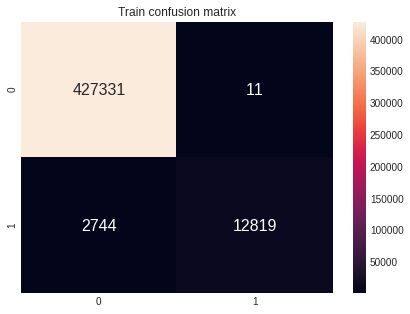

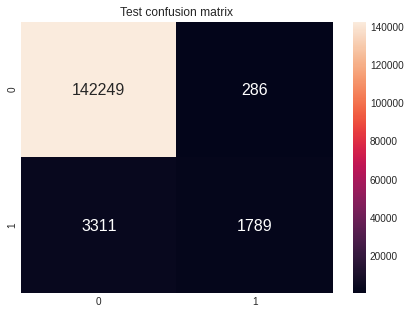

In [ ]:

x_train = X_train[cols]
y_train_pred = model.predict(x_train.iloc[idx_train])
y_test_pred = model.predict(x_train.iloc[idx_validation])

train_fpr, train_tpr, thresholds = roc_curve(y_train.iloc[idx_train], model.predict_proba(x_train.iloc[idx_train])[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_train.iloc[idx_validation], model.predict_proba(x_train.iloc[idx_validation])[:,1])

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


train_cf = confusion_matrix(y_train.iloc[idx_train],y_train_pred)
plt.figure(figsize=(7,5))
sns.heatmap(train_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Train confusion matrix')
plt.show()


cv_cf = confusion_matrix(y_train.iloc[idx_validation],y_test_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cv_cf,annot=True,annot_kws={"size": 16},fmt="0")
plt.title('Test confusion matrix')
plt.show()

In [ ]:
x_test = X_test[cols]
y_pred_test = model.predict_proba(x_test)[:,1]
submission = pd.read_csv('data/sample_submission.csv')
submission['isFraud'] = y_pred_test
submission.to_csv('submission.csv',index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.001049
1,3663550,0.003553
2,3663551,0.004203
3,3663552,0.004760
4,3663553,0.006322


##Local cv : 0.93643
## Private LB: 0.909344
## PublicLB: 0.934270